# Prepare

In [59]:
!pip install pyspark


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# EDA

## Import data

In [60]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, sum, isnull, when, count, lit, rank, dense_rank, to_date, desc, explode, lower
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

spark = (
    SparkSession.builder
    .appName("LinkedInBigDataAnalysi")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "10g")
    .getOrCreate()
)

### Generate Dataframe from the csv data.

In [61]:
file_path_job_skills = "../resources/job_skills.csv"
file_path_job_summary = "../resources/job_summary.csv"
file_path_job_postings = "../resources/linkedin_job_postings.csv"

df_job_skills = spark.read.csv(file_path_job_skills, header=True, escape='"', inferSchema=True)
df_job_summary = spark.read.csv(file_path_job_summary, header=True, escape='"', inferSchema=True)
df_job_postings = spark.read.csv(file_path_job_postings, header=True, escape='"', inferSchema=True)


## Check top 5 data

In [62]:
df_job_skills.show(5,0)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                                                       |job_skills                                              

In [63]:
df_job_summary.show(5,0)

+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|job_link                                                                             |job_summary                                                                                |
+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+
|https://www.linkedin.com/jobs/view/restaurant-manager-at-rock-n-roll-sushi-3805551344|Rock N Roll Sushi is hiring a Restaurant Manager!                                          |
|As our Restaurant Manager                                                            | you’ll never be bored. You’ll be responsible for making sure our restaurant runs smoothly.|
|We Offer                                                                             |NULL         

In [64]:
df_job_postings.show(5,0)

+------------------------------------------------------------------------------------------------------------------------------+-----------------------------+-----------+-------+---------------+--------------------------------------------------------------------------+----------------------------+--------------------+----------+-----------+--------------+------------------------------------+----------+--------+
|job_link                                                                                                                      |last_processed_time          |got_summary|got_ner|is_being_worked|job_title                                                                 |company                     |job_location        |first_seen|search_city|search_country|search_position                     |job_level |job_type|
+------------------------------------------------------------------------------------------------------------------------------+-----------------------------+-----------+

### Define and verify the schema of the dataset

In [65]:
# Display schema of the dataframes
print("Schema of df_job_skills:")
df_job_skills.printSchema()

print("Schema of df_job_summary:")
df_job_summary.printSchema()

print("Schema of df_job_postings:")
df_job_postings.printSchema()

Schema of df_job_skills:
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

Schema of df_job_summary:
root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)

Schema of df_job_postings:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)



## Print the number of rows and columns.

In [66]:
# Print the number of rows and columns
print(f"df_job_skills: {df_job_skills.count()} rows, {len(df_job_skills.columns)} columns")
print(f"df_job_summary: {df_job_summary.count()} rows, {len(df_job_summary.columns)} columns")
print(f"df_job_postings: {df_job_postings.count()} rows, {len(df_job_postings.columns)} columns")

df_job_skills: 1296381 rows, 2 columns


df_job_summary: 48219735 rows, 2 columns
df_job_postings: 1348488 rows, 14 columns


## Obtain the descriptive statistics

In [67]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_skills:")
df_job_skills.describe().show()

Descriptive statistics for df_job_skills:


+-------+--------------------+-------------------------------+
|summary|            job_link|                     job_skills|
+-------+--------------------+-------------------------------+
|  count|             1296381|                        1294374|
|   mean|                NULL|                           NULL|
| stddev|                NULL|                           NULL|
|    min|https://ae.linked...|           $1952 per week, T...|
|    max|https://za.linked...|志愿服务, 沟通, 陪伴, 临终服...|
+-------+--------------------+-------------------------------+



In [68]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_summary:")
df_job_summary.describe().show()

Descriptive statistics for df_job_summary:


+-------+--------------------+--------------------+
|summary|            job_link|         job_summary|
+-------+--------------------+--------------------+
|  count|            48151112|            15572837|
|   mean|5.431919482636374E11|            Infinity|
| stddev|1.995184324038261...|                 NaN|
|    min|        <icon cla...|                    |
|    max|􀀀 Provide servic...|🪠 We invite full...|
+-------+--------------------+--------------------+



In [69]:
# Obtain descriptive statistics
print("Descriptive statistics for df_job_postings:")
df_job_postings.describe().show()

Descriptive statistics for df_job_postings:


+-------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|summary|            job_link| last_processed_time|         got_summary|   got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|search_city|search_country| search_position| job_level|job_type|
+-------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|  count|             1348488|             1348488|             1348488|   1348488|        1348488|             1348488|             1348443|             1348435|   1348454|    1348420|       1348420|         1348420|   1348420| 1348420|
|   mean|                NULL|                NU

# EDA Deep Dive

In [70]:
# Create a new column with the primary skill
df_job_skills_with_primary = df_job_skills.withColumn("primary_skill", split(col("job_skills"), ",")[0])
df_job_skills_with_primary.show(5, 0)

+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------+
|job_link                                                                                                                       |job_skills              

In [71]:
# Aggregate functions
# Count of jobs by job level
df_job_postings.groupBy("job_level").count().show()

# Count of jobs by job type
df_job_postings.groupBy("job_type").count().show()

+----------+-------+
| job_level|  count|
+----------+-------+
|      NULL|     68|
| Associate| 144009|
|Mid senior|1204411|
+----------+-------+

+--------+-------+
|job_type|  count|
+--------+-------+
|  Remote|   4259|
|  Onsite|1337599|
|    NULL|     68|
|  Hybrid|   6562|
+--------+-------+



In [72]:
# Grouping and Sorting
# Group by company and count job postings, then sort
company_counts = df_job_postings.groupBy("company").count().sort("count", ascending=False)
company_counts.show(10)

+--------------------+-----+
|             company|count|
+--------------------+-----+
|     Health eCareers|41598|
|   Jobs for Humanity|27680|
|   TravelNurseSource|16142|
|      Dollar General|14815|
|        PracticeLink| 9738|
|      Energy Jobline| 9365|
|Gotham Enterprise...| 8935|
|               Jobot| 8713|
|       ClearanceJobs| 8599|
|          McDonald's| 8125|
+--------------------+-----+
only showing top 10 rows


In [73]:
# Count of jobs by job type
df_job_postings.groupBy("first_seen").count().show()

+----------+------+
|first_seen| count|
+----------+------+
|2024-01-13|404049|
|2024-01-14|460024|
|    Onsite|    34|
|      NULL|    34|
|2024-01-17| 36028|
|2024-01-16|157057|
|2024-01-12|206186|
|2024-01-15| 85076|
+----------+------+



In [74]:
df_job_postings = df_job_postings.filter(col("first_seen").rlike("^\\d{4}-\\d{2}-\\d{2}$"))
df_job_postings.groupBy("first_seen").count().show()

+----------+------+
|first_seen| count|
+----------+------+
|2024-01-13|404049|
|2024-01-14|460024|
|2024-01-17| 36028|
|2024-01-16|157057|
|2024-01-12|206186|
|2024-01-15| 85076|
+----------+------+



## JOIN dataframe on job link

In [75]:
# Join df_job_postings and df_job_skills
df_joined = df_job_postings.join(df_job_skills, "job_link", "inner")
df_joined.show(5)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen| search_city|search_country|   search_position| job_level|job_type|          job_skills|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|https://ae.linked...|2024-01-21 07:21:...|          t|      t|              f|        EVS Operator|              Sundus|Abu Dhabi, Abu Dh...|2024-01-17|Saint Joseph| United States|     Unit Operator|Mid senior|  Onsite|EVS, EVS Operator...|
|https://ae.linked...|2024-01-21

## Count Missing Values

In [76]:
# Count missing values in df_job_postings
df_job_postings.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_postings.columns]).show()

# Count missing values in df_job_summary
df_job_summary.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_summary.columns]).show()

# Count missing values in df_job_skills
df_job_skills.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_job_skills.columns]).show()

+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+
|       0|                  0|          0|      0|              0|        0|     11|          19|         0|          0|             0|              0|        0|       0|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+



+--------+-----------+
|job_link|job_summary|
+--------+-----------+
|   68623|   32646898|
+--------+-----------+

+--------+----------+
|job_link|job_skills|
+--------+----------+
|       0|      2007|
+--------+----------+



## Fill missing values in job summary dataframe

In [77]:
# Fill missing values in df_job_summary
df_job_summary_cleaned = df_job_summary.fillna({"job_summary": "No summary available"})
df_job_summary_cleaned.filter(col("job_summary") == "No summary available").show(5)

+--------------------+--------------------+
|            job_link|         job_summary|
+--------------------+--------------------+
|            We Offer|No summary available|
|Competitive compe...|No summary available|
|  Insurance benefits|No summary available|
| Bonus opportunities|No summary available|
|A great work atmo...|No summary available|
+--------------------+--------------------+
only showing top 5 rows


## Drop rows missing job skills

In [78]:
# Drop rows with missing job_skills in df_job_skills
df_job_skills_cleaned = df_job_skills.dropna(subset=["job_skills"])
print(f"Original df_job_skills count: {df_job_skills.count()}")
print(f"Cleaned df_job_skills count: {df_job_skills_cleaned.count()}")

Original df_job_skills count: 1296381
Cleaned df_job_skills count: 1294374


## Drop rows missing job postings

In [79]:
# Drop rows with missing values in key columns of df_job_postings
df_job_postings_cleaned = df_job_postings.dropna(subset=["job_title", "company", "job_location"])
print(f"Original df_job_postings count: {df_job_postings.count()}")
print(f"Cleaned df_job_postings count: {df_job_postings_cleaned.count()}")

Original df_job_postings count: 1348420
Cleaned df_job_postings count: 1348390


## JOIN

In [80]:
# Join df_job_postings and df_job_skills
df_joined = df_job_postings.join(df_job_skills, "job_link", "inner")
df_joined.show(5)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen| search_city|search_country|   search_position| job_level|job_type|          job_skills|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+------------+--------------+------------------+----------+--------+--------------------+
|https://ae.linked...|2024-01-21 07:21:...|          t|      t|              f|        EVS Operator|              Sundus|Abu Dhabi, Abu Dh...|2024-01-17|Saint Joseph| United States|     Unit Operator|Mid senior|  Onsite|EVS, EVS Operator...|
|https://ae.linked...|2024-01-21

# IT Job Deep Dive

In [81]:
# IT Keyword Filter Definition (Expanded)
strict_keywords = [
    "AI", "IT", "Web", "QA", "UI", "UX", "ML", "SRE", "NLP", "IOT", "ERP", "SAAS", 
    "API", "SDK", "ETL", "BI", "DBA", "AR", "VR", "XR", "GIS"
]
broad_keywords = [
    "Software", "Developer", "Engineer", "Data", "Analyst", "Cyber", 
    "Cloud", "Network", "System", "Database", "Machine Learning", 
    "DevOps", "Programmer", "Technical", "Information Technology",
    "Security", "Architect", "Scrum", "Product Owner", "Java", "Python", "Javascript",
    "Full Stack", "Backend", "Frontend", "Mobile", "Firmware", "Blockchain", 
    "Data Scientist", "Robotics", "Automation", "Reliability", "Platform", "Infrastructure",
    "Support", "Technician", "Help Desk", "Service Desk", "Admin", "SysAdmin", "Technology", "IT",
    "Automation", "Developer", "Architect"
]
tech_keywords = (
    "React", "Angular", "Vue", "Node", "AWS", "Azure", "GCP", "Linux", "Docker", 
    "Kubernetes", "Terraform", "Ansible", "Jenkins", "Salesforce", "Oracle", "SAP", 
    "C#", "C++", "Golang", "Rust", "Swift", "Kotlin", "Flutter", "TensorFlow", "PyTorch",
    "Python", "SQL", "HTML", "CSS", "JavaScript", "TypeScript", "PHP", "Ruby", "Perl", "Go", "R",       
    "API", "Agile","C++", "C", "Cloud Computing", "Machine Learning",  "Jira", "Software Engineering",
    "Go", "React", "Microservices", "Jenkins", "Power BI", "SAP", "R", "Ansible", "Oracle", "Active Directory",
    "Terraform", "NoSQL", "CI/CD", "GCP", "Statistics", "Scripting", "SQL Server", "Azure", "Git", "TypeScript", "Spark",
    "Hadoop", "Tableau", "Bash", "Perl", "Ruby", "PHP", "Python"
)

strict_regex = "|".join([f"\\b{k}\\b" for k in strict_keywords])
broad_regex = "|".join(broad_keywords)
tech_regex = "|".join([f"\\b{k}\\b" for k in tech_keywords])
combined_regex = f"(?i)({strict_regex}|{broad_regex}|{tech_regex})"

# Exclusion keywords (Refined based on validation)
exclusion_keywords = [
    "Civil", "Mechanical", "Chemical", "Nurse", "Driver", "Construction", 
    "Financial Analyst", "Accountant", "Sales Manager", "Office Manager", "Clerk",
    "Electrician", "Plumber", "Store Manager", "Warehouse", "Operator",
    "Pharmacy", "Medical", "Dental", "Legal"
]
exclusion_regex = "|".join(exclusion_keywords)
combined_exclusion = f"(?i)({exclusion_regex})"

# Apply Filter (Include IT keywords AND Exclude Non-IT keywords)
df_it_jobs = df_joined.filter(
    col("job_title").rlike(combined_regex) & 
    ~col("job_title").rlike(combined_exclusion)
)

print(f"Total Jobs: {df_job_postings_cleaned.count()}")
print(f"IT Jobs Filtered: {df_it_jobs.count()}")

Total Jobs: 1348390


IT Jobs Filtered: 336469


## Validation: False Negatives
Checking what we exclude.


In [82]:
# Jobs NOT matching the filter
df_non_it = df_joined.filter(~col("job_title").rlike(combined_regex))

# Top 20 Non-IT Job Titles
print("Top 20 Job Titles EXCLUDED by Filter (Potential False Negatives):")
df_non_it.groupBy("job_title").count().orderBy(desc("count")).show(20, truncate=False)


Top 20 Job Titles EXCLUDED by Filter (Potential False Negatives):


+---------------------------------------------------+-----+
|job_title                                          |count|
+---------------------------------------------------+-----+
|LEAD SALES ASSOCIATE-FT                            |7315 |
|Shift Manager                                      |5500 |
|First Year Tax Professional                        |5351 |
|Customer Service Representative                    |5165 |
|Assistant Manager                                  |5067 |
|LEAD SALES ASSOCIATE-PT                            |4911 |
|Store Manager                                      |4739 |
|CUSTOMER SERVICE REPRESENTATIVE                    |4214 |
|Registered Nurse                                   |4142 |
|Hourly Supervisor & Training                       |2883 |
|Host                                               |2861 |
|Travel Allied Health Professional - CT Technologist|2717 |
|Account Executive                                  |2614 |
|Senior Accountant                      

## Date Analysis

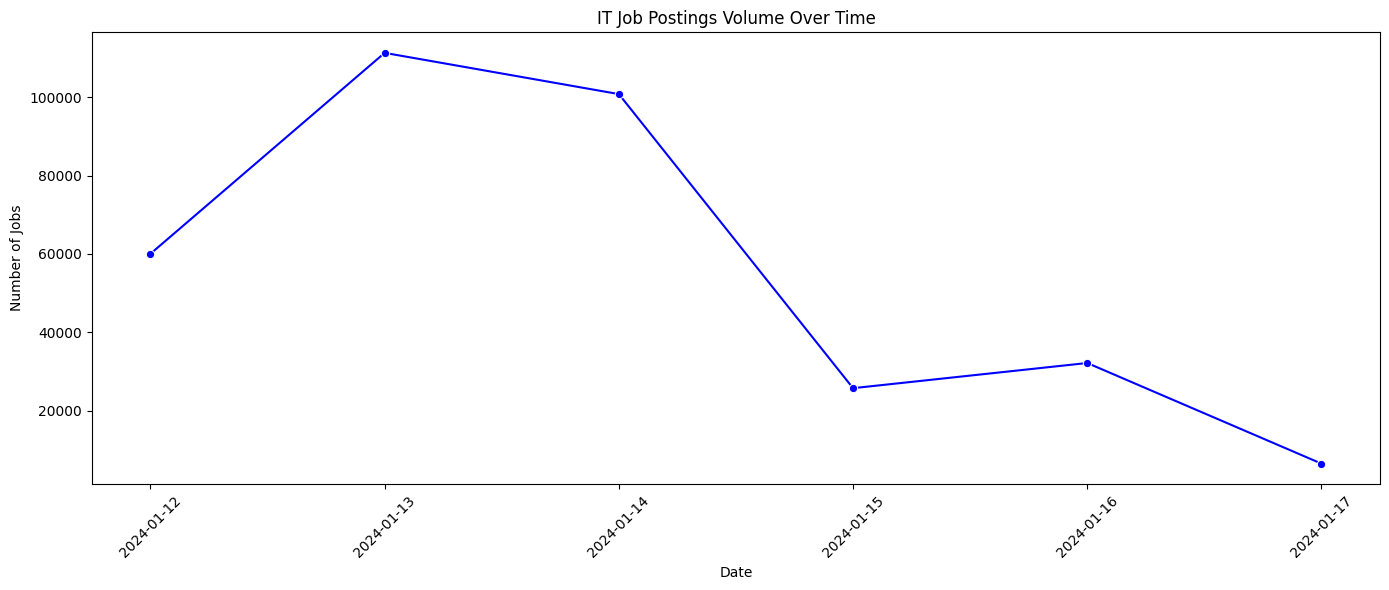

In [83]:
# Prepare Data for Plotting (Convert to Pandas)
df_trend = df_it_jobs.withColumn("date", to_date(col("first_seen")))\
    .groupBy("date")\
    .count()\
    .orderBy("date")\
    .toPandas()

# Plotting Job Volume
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_trend, x="date", y="count", marker="o", color="b")
plt.title("IT Job Postings Volume Over Time")
plt.ylabel("Number of Jobs")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Job Type Analysis

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/2911319679.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




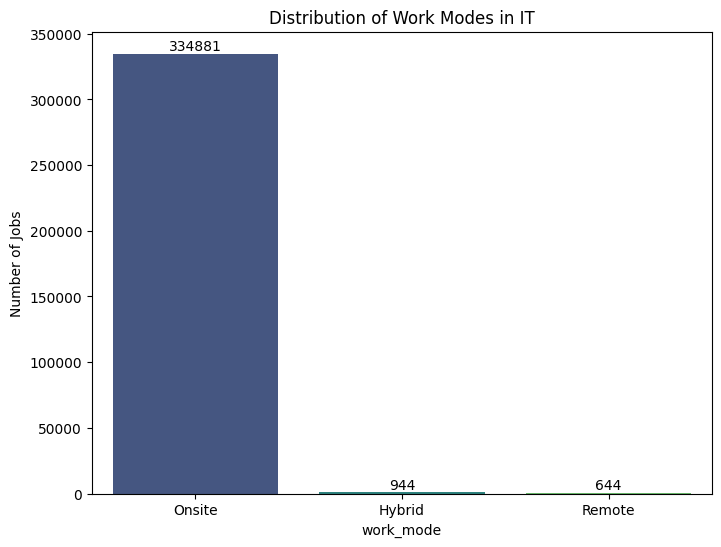

In [84]:
df_it_jobs = df_it_jobs.withColumn(
    "work_mode", 
    when(lower(col("job_type")).rlike("remote"), "Remote")
    .when(lower(col("job_type")).rlike("hybrid"), "Hybrid")
    .when(lower(col("job_type")).rlike("onsite"), "Onsite")
    .otherwise("Unknown")
)

df_work_mode = df_it_jobs.groupBy("work_mode").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_work_mode, x="work_mode", y="count", palette="viridis")
plt.title("Distribution of Work Modes in IT")
plt.ylabel("Number of Jobs")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

## Skills Analysis

Verified Top Skills:
                     skill  count
0            Communication  78426
1                 Teamwork  47271
2               Leadership  35819
3       Project Management  33228
4          Problem Solving  27205
5     Communication skills  26161
6          Troubleshooting  25549
7            Collaboration  23666
8     Communication Skills  22757
9                   Python  22031
10        Customer service  20522
11          Problemsolving  19931
12  Microsoft Office Suite  19658
13                     SQL  18343
14           Data Analysis  18300
15        Customer Service  17378
16        Microsoft Office  16889
17     Attention to detail  16864
18      Project management  16312
19     Attention to Detail  15432


/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/3626721732.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




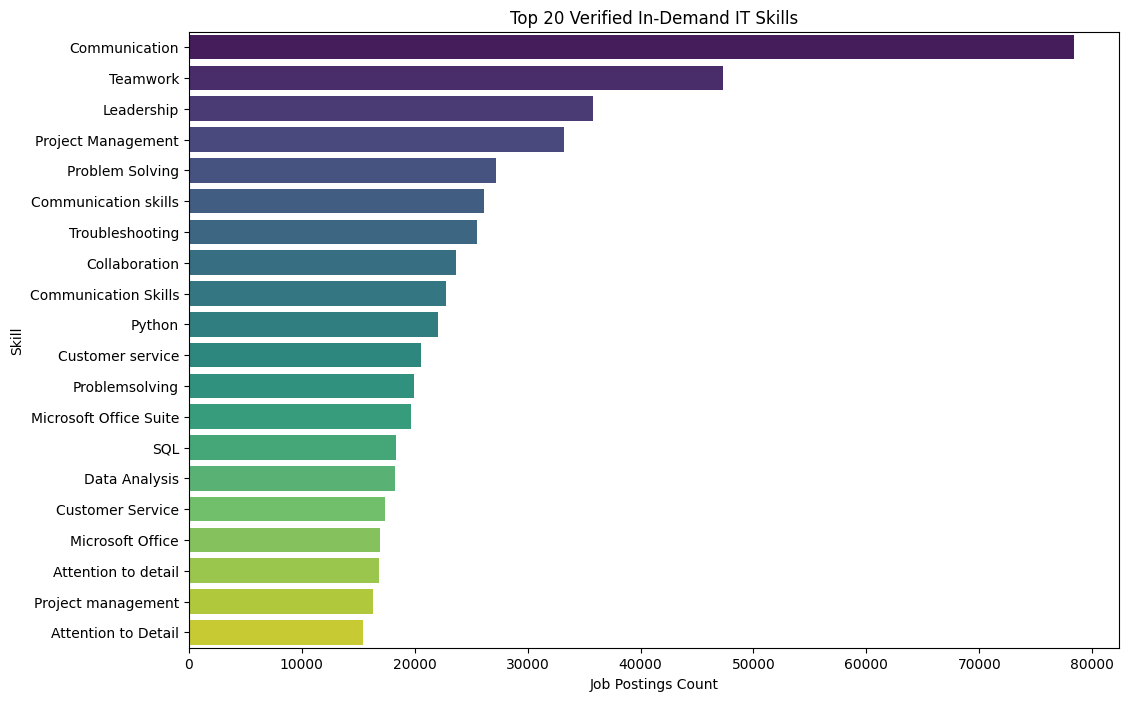

In [85]:
# Verified Skills Analysis (Join Method)
# Using strict inner join to ensure we only count skills for the filtered IT jobs
df_it_skills = df_it_jobs.select("job_link").join(df_job_skills, "job_link", "inner")

# Explode and Clean
from pyspark.sql.functions import explode, split, col, trim, desc, lower
df_skills_exploded = df_it_skills.select(explode(split(col("job_skills"), ",")).alias("skill"))
df_skills_exploded = df_skills_exploded.withColumn("skill", trim(col("skill")))
df_skills_exploded = df_skills_exploded.filter(col("skill") != "")

# Count Top 20
skill_counts = df_skills_exploded.groupBy("skill").count().orderBy(desc("count")).limit(20)
pdf_skills = skill_counts.toPandas()

# Display Table
print("Verified Top Skills:")
print(pdf_skills)

# Plot Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(data=pdf_skills, x="count", y="skill", palette="viridis")
plt.title("Top 20 Verified In-Demand IT Skills")
plt.xlabel("Job Postings Count")
plt.ylabel("Skill")
plt.show()


## Location Analysis

In [91]:
# Aggregating by Country for Map
df_geo_country = df_it_jobs.filter(col("search_country").isNotNull())\
    .groupBy("search_country")\
    .count()\
    .orderBy(desc("count"))\
    .toPandas()

fig = px.choropleth(
    df_geo_country,
    locations="search_country",
    locationmode="country names",
    color="count",
    hover_name="search_country",
    title="Global IT Job Distribution",
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.show()

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/646397901.py:8: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/1296751226.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




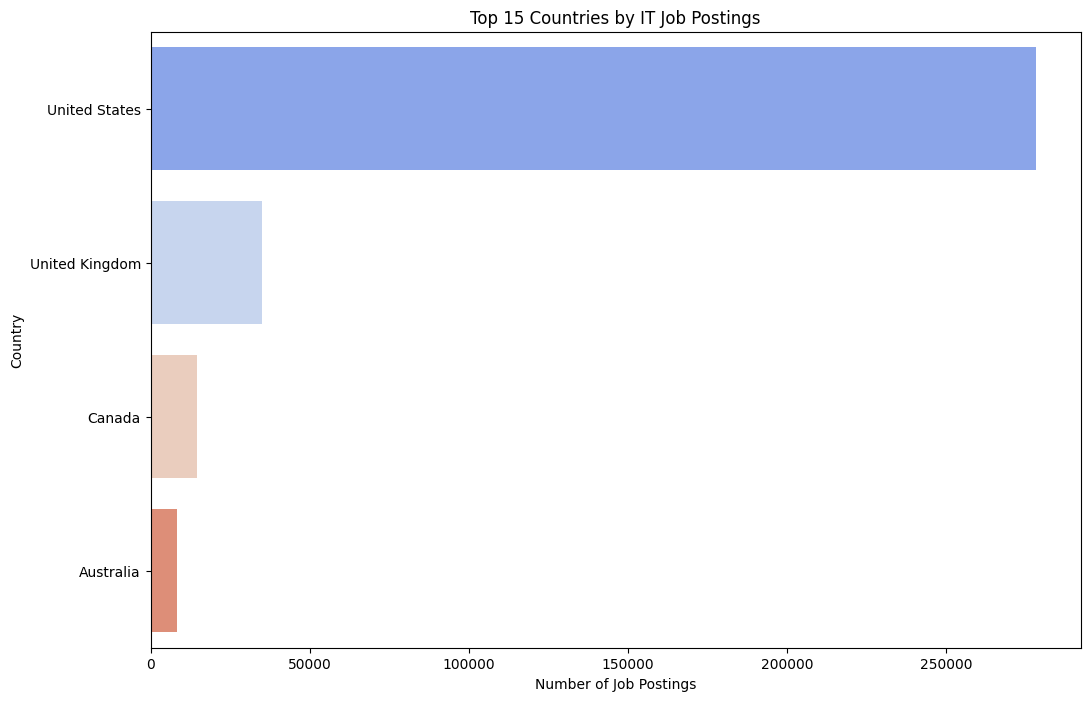

In [86]:
# Country Distribution Analysis (Verified)
country_counts = df_it_jobs.filter(col("search_country").isNotNull()) \
                        .groupBy("search_country") \
                        .count() \
                        .orderBy(desc("count")) \
                        .limit(15)

pdf_country = country_counts.toPandas()

# Plot Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(data=pdf_country, x="count", y="search_country", palette="coolwarm")
plt.title("Top 15 Countries by IT Job Postings")
plt.xlabel("Number of Job Postings")
plt.ylabel("Country")
plt.show()


/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/2643034661.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




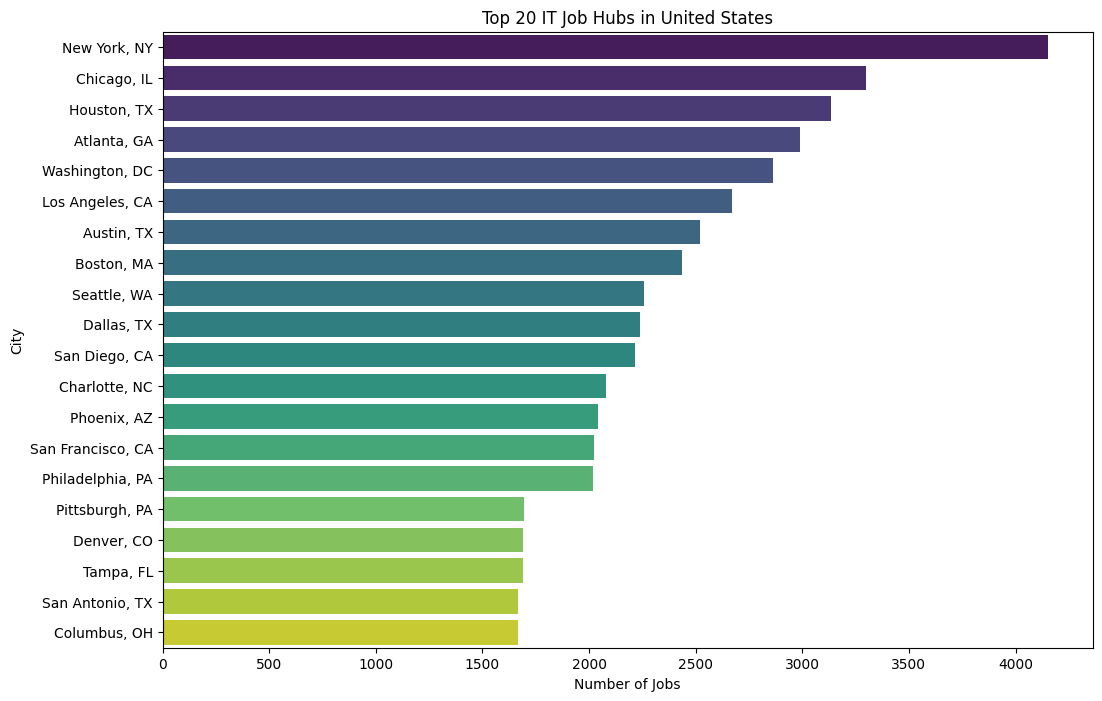

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/2643034661.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




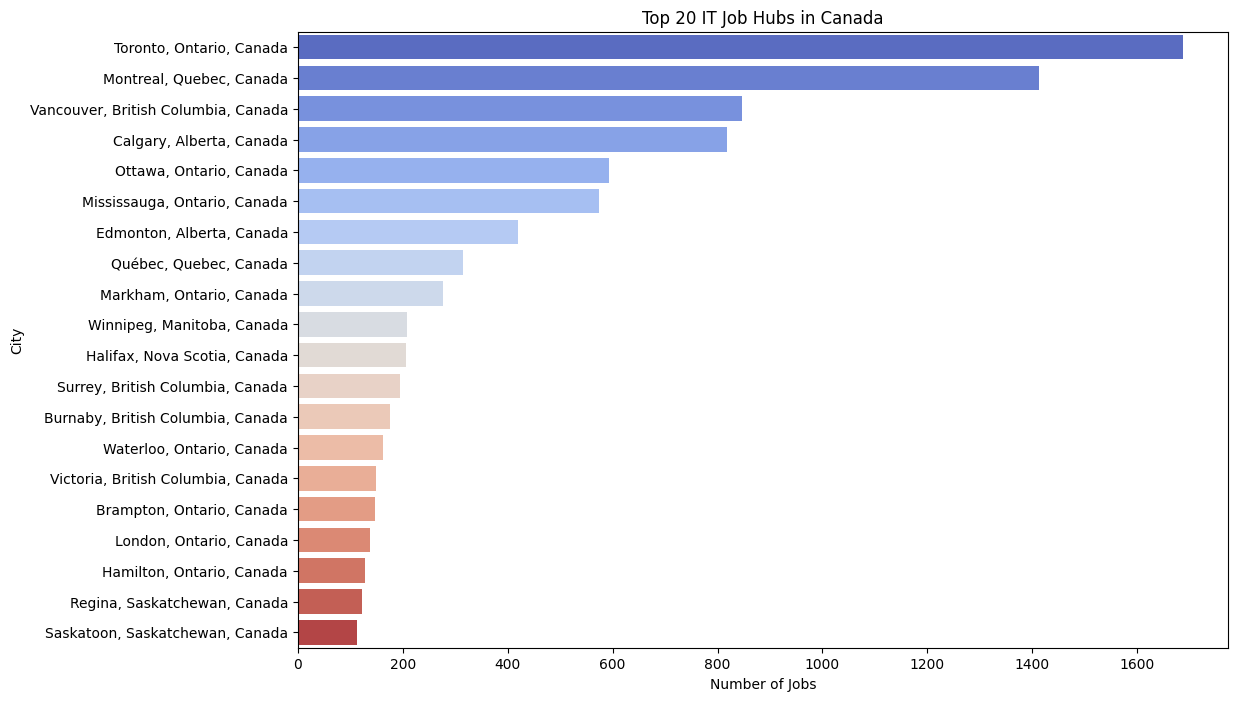

In [87]:
# City-Level Analysis (US & Canada)
# Filter for US and Canada only
df_geo_city = df_it_jobs.filter(col("search_country").isin(["United States", "Canada"]))

# Group by Location (City, State)
# We use 'job_location' as it usually contains "City, State"
df_city_counts = df_geo_city.filter(col("job_location").isNotNull())\
    .groupBy("search_country", "job_location")\
    .count()\
    .orderBy(desc("count"))\
    .toPandas()

# Separate US and Canada for cleaner plots
df_us_cities = df_city_counts[df_city_counts['search_country'] == 'United States'].head(20)
df_ca_cities = df_city_counts[df_city_counts['search_country'] == 'Canada'].head(20)

# Plot Top 20 US Cities
plt.figure(figsize=(12, 8))
sns.barplot(data=df_us_cities, y="job_location", x="count", palette="viridis")
plt.title("Top 20 IT Job Hubs in United States")
plt.xlabel("Number of Jobs")
plt.ylabel("City")
plt.show()

# Plot Top 20 Canadian Cities
plt.figure(figsize=(12, 8))
sns.barplot(data=df_ca_cities, y="job_location", x="count", palette="coolwarm")
plt.title("Top 20 IT Job Hubs in Canada")
plt.xlabel("Number of Jobs")
plt.ylabel("City")
plt.show()

## Job Cluster Analysis

/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/3590776762.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




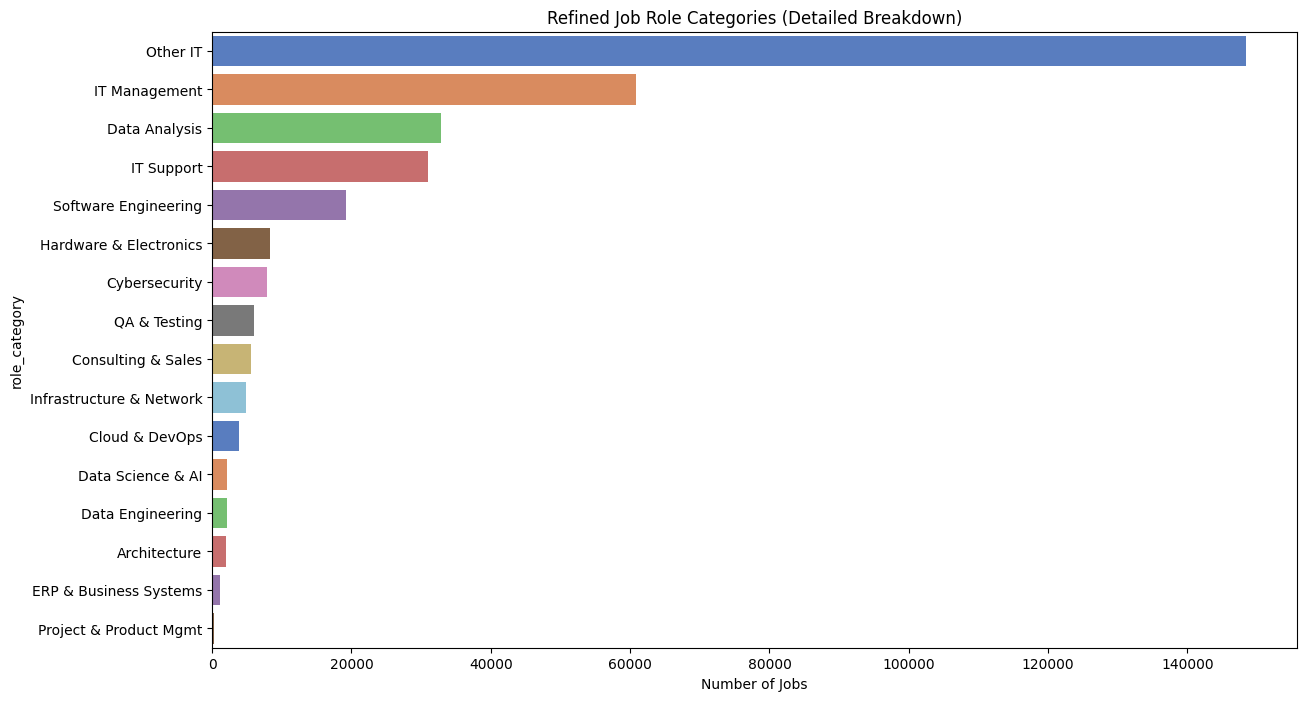

In [88]:
df_roles = df_it_jobs.withColumn(
    "role_category",
    when(col("job_title").rlike("(?i)data scientist|machine learning|ai engineer|research scientist"), "Data Science & AI")
    .when(col("job_title").rlike("(?i)data engineer|etl|big data|pipeline"), "Data Engineering")
    .when(col("job_title").rlike("(?i)analyst|analytics|bi developer|tableau|power bi"), "Data Analysis")
    .when(col("job_title").rlike("(?i)software engineer|developer|programmer|full stack|backend|frontend"), "Software Engineering")
    .when(col("job_title").rlike("(?i)cloud|devops|sre|reliability|platform engineer"), "Cloud & DevOps")
    .when(col("job_title").rlike("(?i)solutions? architect|technical architect|system architect|enterprise architect"), "Architecture")
    .when(col("job_title").rlike("(?i)manager|director|lead|head|vp|chief"), "IT Management")
    .when(col("job_title").rlike("(?i)project manager|product manager|scrum|agile|product owner"), "Project & Product Mgmt")
    .when(col("job_title").rlike("(?i)qa|test|quality assurance|automation"), "QA & Testing")
    .when(col("job_title").rlike("(?i)consultant|solution|sales engineer|pre-sales|technical account"), "Consulting & Sales")
    .when(col("job_title").rlike("(?i)erp|crm|sap|salesforce|oracle|dynamics|jde|jd edwards"), "ERP & Business Systems")
    .when(col("job_title").rlike("(?i)support|technician|help desk|service desk"), "IT Support")
    .when(col("job_title").rlike("(?i)network|system admin|infrastructure|sysadmin"), "Infrastructure & Network")
    .when(col("job_title").rlike("(?i)cyber|security|infosec"), "Cybersecurity")
    .when(col("job_title").rlike("(?i)hardware|embedded|firmware|iot|electrical|controls"), "Hardware & Electronics")
    .otherwise("Other IT")
).groupBy("role_category").count().orderBy(desc("count")).toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(data=df_roles, y="role_category", x="count", palette="muted")
plt.title("Refined Job Role Categories (Detailed Breakdown)")
plt.xlabel("Number of Jobs")
plt.show()

## Vancluver Deep Dive

Total IT Jobs in Vancouver: 1188


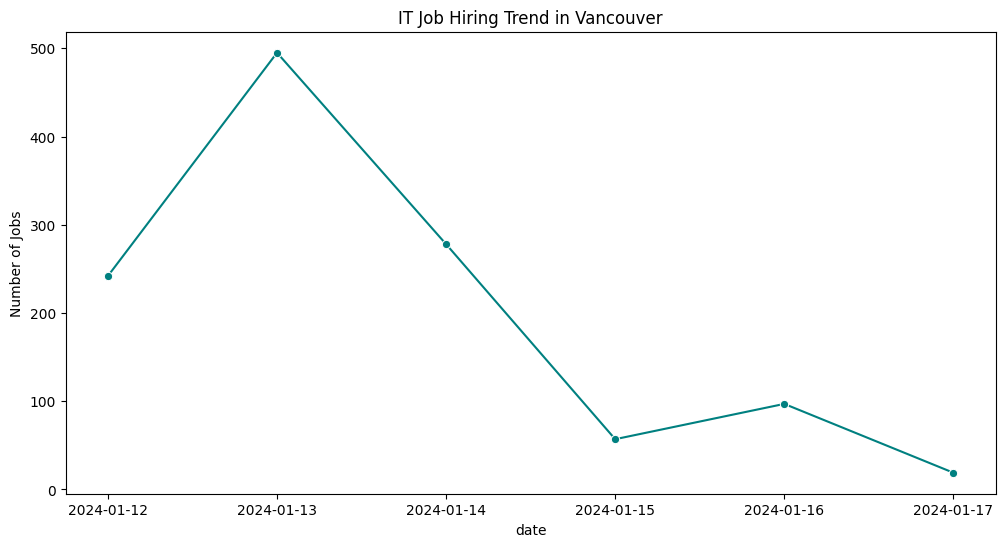


--- Top 10 IT Roles in Vancouver ---


+--------------------------------------------------------------------------------------------------------------------------+-----+
|job_title                                                                                                                 |count|
+--------------------------------------------------------------------------------------------------------------------------+-----+
|ZFRCE Budget Analyst                                                                                                      |16   |
|Administrative Assistant Part Time Work From Home (Dr. Renee Joy Dufault)                                                 |14   |
|Software Test Engineer 3                                                                                                  |6    |
|Administrative Assistant                                                                                                  |5    |
|CST Peer Mentor – Clerical Support, Forensic Psychiatric Regional Clinic – Vancouv

In [89]:
# Vancouver Deep Dive
# Filtering for 'Vancouver' in job_location
df_van = df_it_jobs.filter(col("job_location").rlike("(?i)Vancouver"))
print(f"Total IT Jobs in Vancouver: {df_van.count()}")

# Vancouver Trends
df_van_trend = df_van.withColumn("date", to_date(col("first_seen")))\
    .groupBy("date")\
    .count()\
    .orderBy("date")\
    .toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_van_trend, x="date", y="count", marker="o", color="teal")
plt.title("IT Job Hiring Trend in Vancouver")
plt.ylabel("Number of Jobs")
plt.show()

# Top Roles in Vancouver
print("\n--- Top 10 IT Roles in Vancouver ---")
df_van.groupBy("job_title").count().orderBy(desc("count")).show(10, truncate=False)




/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/497964623.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/11/_4nf9vcd381d35kpvnpx8jph0000gn/T/ipykernel_81152/497964623.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




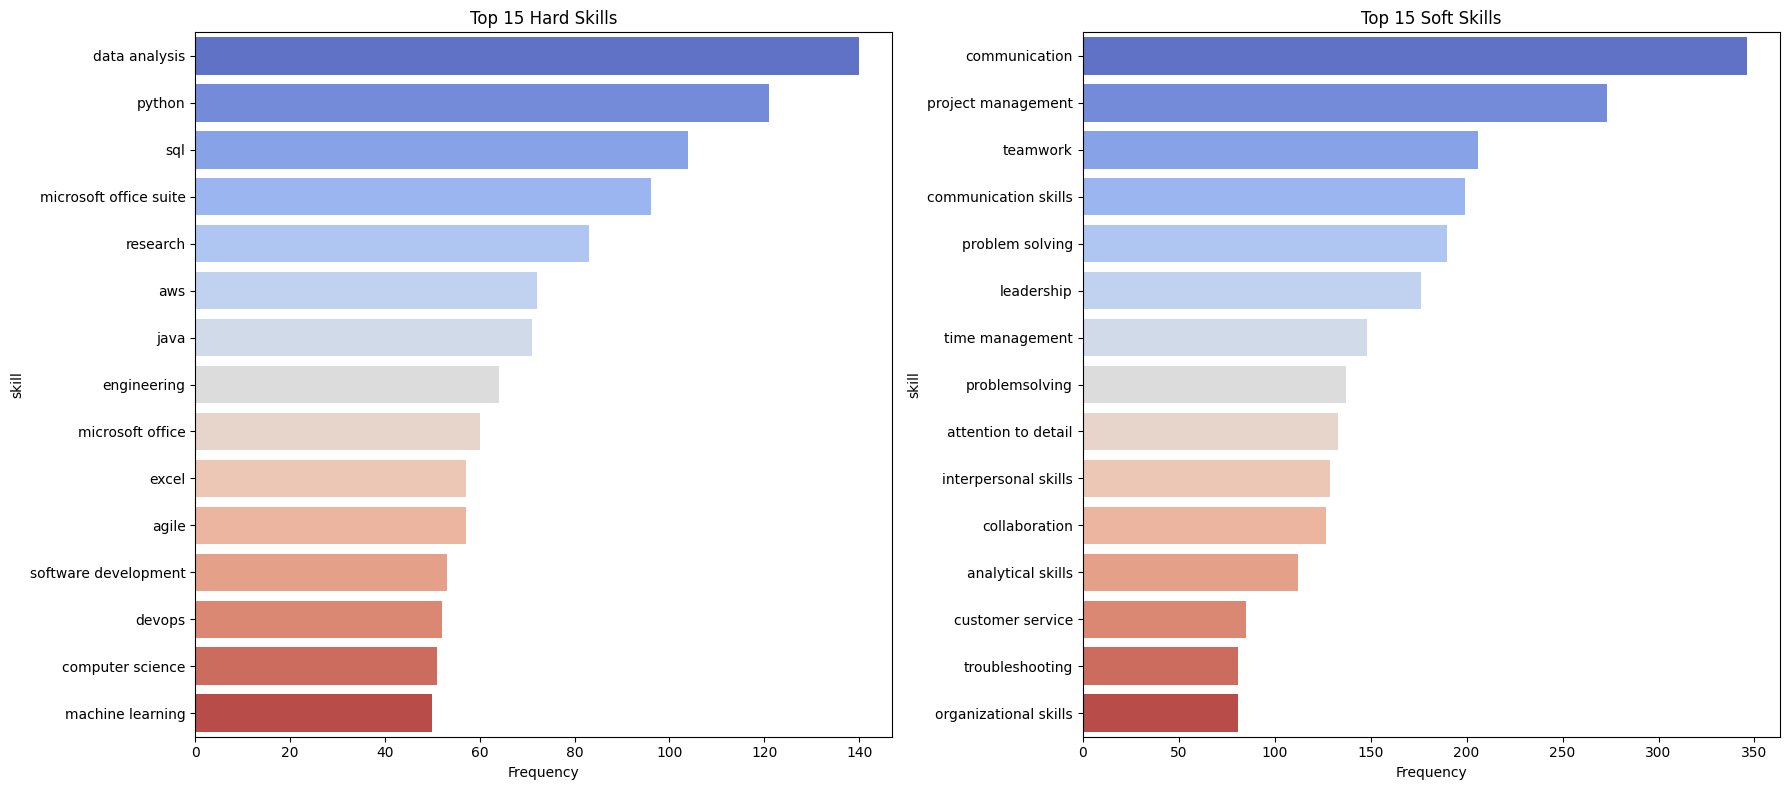

In [90]:
# Explode skills
df_van_skills = df_van.filter(col("job_skills").\
                            isNotNull()).\
                            withColumn("skill", explode(split(lower(col("job_skills")), ",\\s*"))).\
                            groupBy("skill").\
                            count().\
                            orderBy(desc("count")).\
                            toPandas()

# Categorize in Pandas
def categorize_skill(skill_name):
    s_clean = str(skill_name).lower()
    if any(soft in s_clean for soft in soft_skills_lower):
        return "Soft Skill"
    return "Hard Skill"

df_van_skills["Category"] = df_van_skills["skill"].apply(categorize_skill)

# Top 15 Hard Skills
top_hard = df_van_skills[df_van_skills["Category"] == "Hard Skill"].head(15)

# Top 15 Soft Skills
top_soft = df_van_skills[df_van_skills["Category"] == "Soft Skill"].head(15)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Hard Skills
sns.barplot(data=top_hard, y="skill", x="count", ax=axes[0], palette="coolwarm")
axes[0].set_title("Top 15 Hard Skills")
axes[0].set_xlabel("Frequency")

# Soft Skills
sns.barplot(data=top_soft, y="skill", x="count", ax=axes[1], palette="coolwarm")
axes[1].set_title("Top 15 Soft Skills")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()